In [1]:
import time
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import os, errno

In [2]:
def erodeimg(image):
    kernel = np.ones((4,4), np.uint8)
    erode = cv2.erode(image, kernel, iterations = 1)
    return erode

In [3]:
def dilateimg(image):
    kernel = np.ones((3,3), np.uint8)
    dilate = cv2.dilate(image, kernel, iterations = 1)
    return dilate

In [4]:
def MotionParameters(image):
    eroded = erodeimg(image)
    dilated = dilateimg(eroded)


    mask = cv2.inRange(dilated, 5, 200)
    kernel = np.ones((10,10), np.uint8)
    close = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    _, contours, hierarchy = cv2.findContours(close, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    area = [cv2.contourArea(c) for c in contours]
    areas = np.asarray(area)
    areas[areas < 500] = 0
    
    if (len(contours) >= 1) & np.any(areas):
        max_i = np.argmax(areas)
        contour_ = contours[max_i]
        contour_h = cv2.convexHull(contour_)
        
        M = cv2.moments(contour_)
        hM = cv2.moments(contour_h)
        centroid_ = (int(M["m10"]/M["m00"])), (int(M["m01"]/M["m00"]))
        centroid_h = (int(hM["m10"]/hM["m00"])), (int(hM["m01"]/hM["m00"]))
    else:
        contour_ = ()
        contour_h = ()
        centroid_ = (np.nan, np.nan)
        centroid_h = (np.nan, np.nan)
    return contour_, contour_h, centroid_, centroid_h

In [5]:
def VideoPull(back_frame, current_frame, file_name, path):
    video = [(os.path.join(root, file), file[0:-4]) 
        for root, dirs, files in os.walk(path) 
        for file in files 
        if file.endswith(file_name + '.mp4')]
    cam = cv2.VideoCapture(video[0][0])
    cam.set(1,back_frame)
    ret, f = cam.read(1)
    background = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
    cam.set(1,current_frame)
    ret, c = cam.read(1)
    current = cv2.cvtColor(c, cv2.COLOR_BGR2GRAY)
    difference = cv2.subtract(current,background)

    return background, current, difference

In [6]:
def FrameSequence(file_name, path):
    video = [(os.path.join(root, file), file[0:-4]) 
        for root, dirs, files in os.walk(path) 
        for file in files 
        if file.endswith(file_name + '.mp4')]
    cam = cv2.VideoCapture(video[0][0])
    cam.set(1,0)
    frame_sequence = list(range(0,int(cam.get(cv2.CAP_PROP_FRAME_COUNT))))

    return frame_sequence

In [10]:
filename = 'L0.1_c-3_m12'
location = '/Users/Mahad/Documents/Python_Folder/Lightlevel-FlowerShape/Videos/'
outpath = '/Users/Mahad/Documents/GitHub2/ManducaMultiSenseFeeding/Method_Fig/'

In [11]:
frames = FrameSequence(filename, location)

In [13]:
start_frame = 29811-50
end_frame = 30085+50
frameNum = frames[start_frame:end_frame]
contours = []
centroids_x = []
centroids_y = []
contours_hull = []
centroids_hull_x = []
centroids_hull_y = []
frame_ = []

i = 0
for frame in frameNum:
    back, cur, diff = VideoPull(0,frame, filename, location)
    contour, contour_hull, centroid, centroid_hull = MotionParameters(diff)
    contours.append(contour)
    centroids_x.append(centroid[0])
    centroids_y.append(centroid[1])
    contours_hull.append(contour_hull)
    centroids_hull_x.append(centroid_hull[0])
    centroids_hull_y.append(centroid_hull[1])
    frame_.append(frame)

new_df = (pd.DataFrame({'X_position' : centroids_hull_x, 
                            'Y_position' : centroids_hull_y, 
                            'FrameNumber' : frame_}))

new_df.to_csv(outpath + 'Final_position_centroid_method_LastTrial_' + filename + '.csv')

In [14]:
gauss = signal.gaussian(3,3)
x_gauss = signal.convolve(centroids_hull_x, gauss, mode='same', method = 'direct') / gauss.sum()
y_gauss = signal.convolve(centroids_hull_y, gauss, mode = 'same', method = 'direct') / gauss.sum()

/Users/Mahad/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


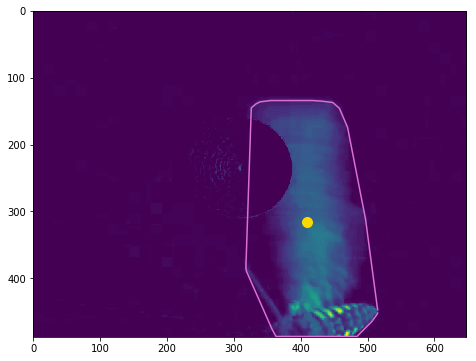

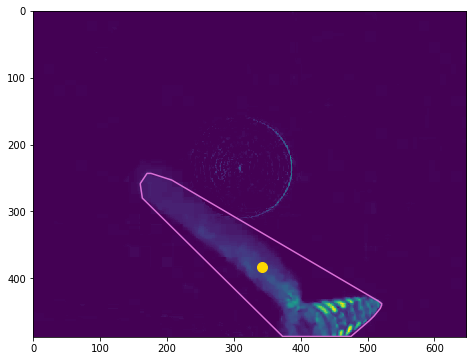

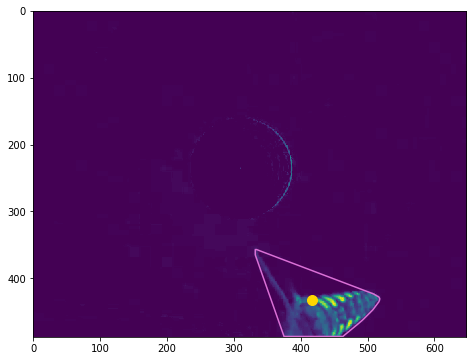

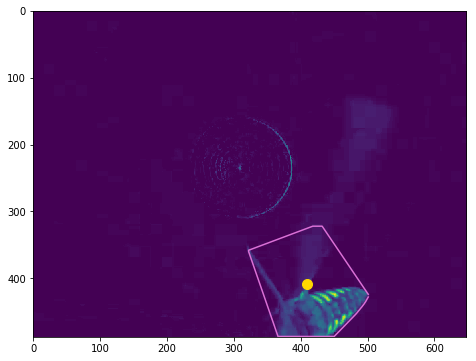

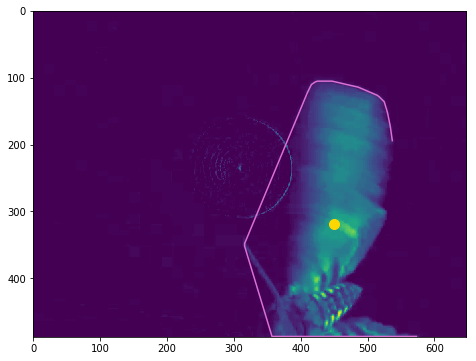

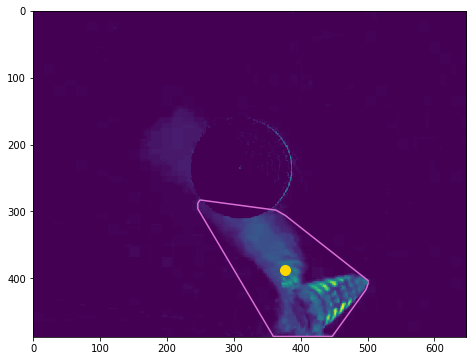

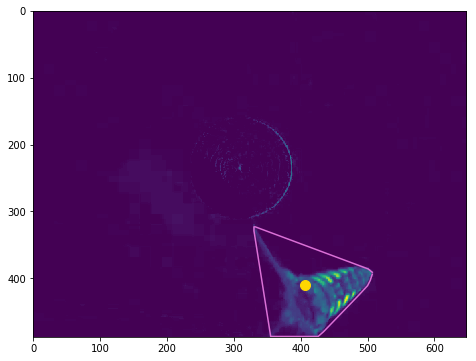

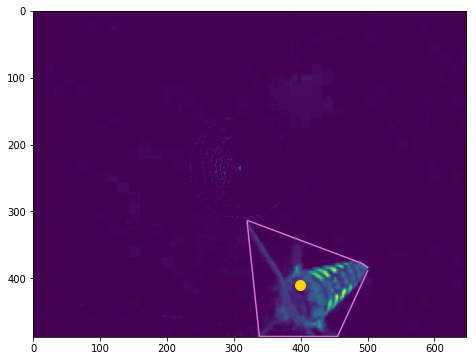

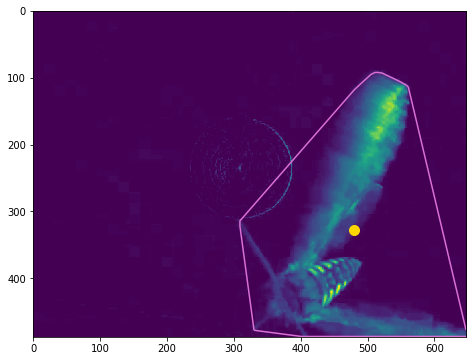

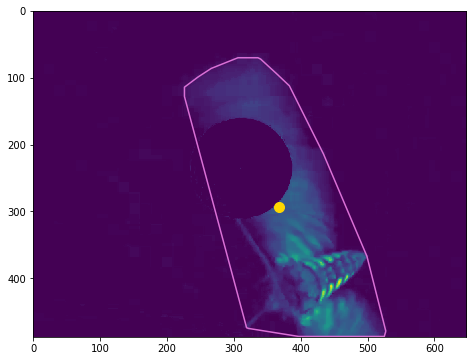

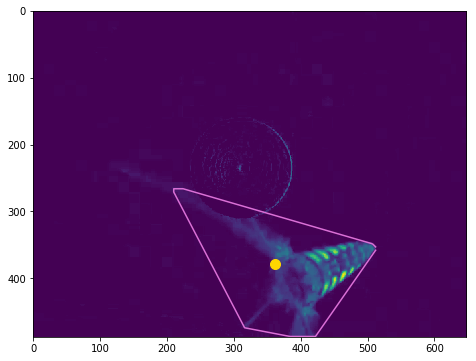

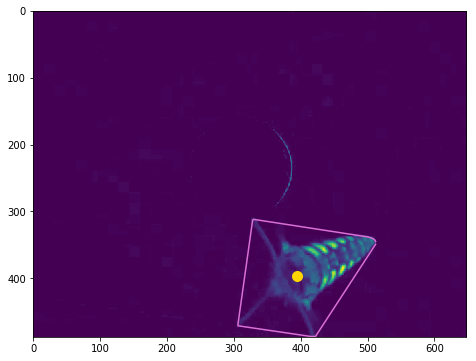

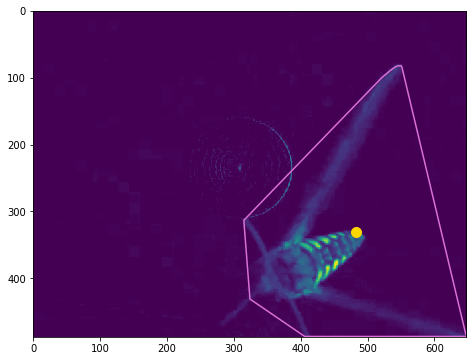

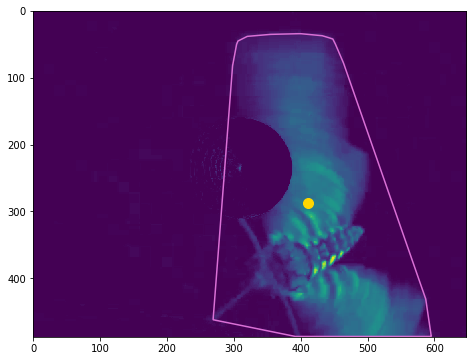

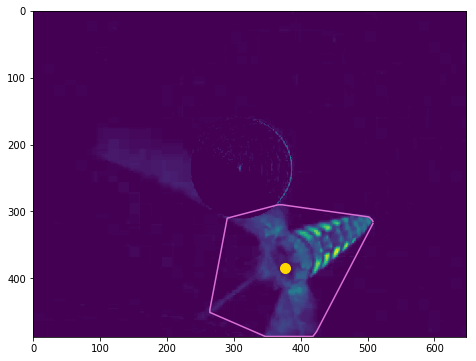

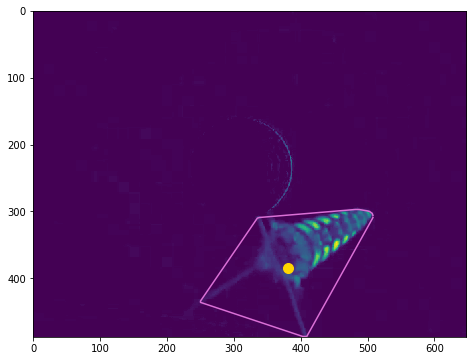

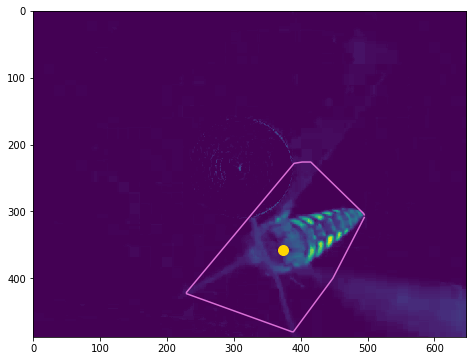

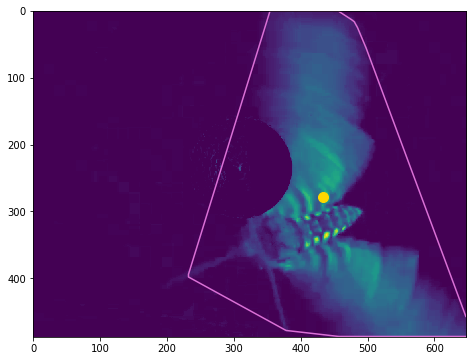

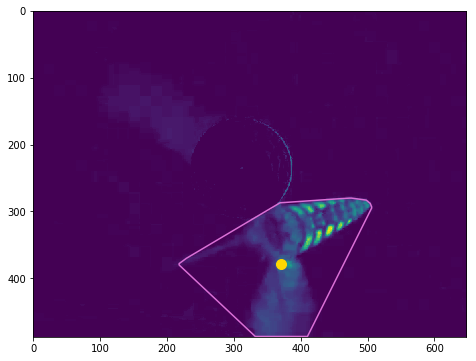

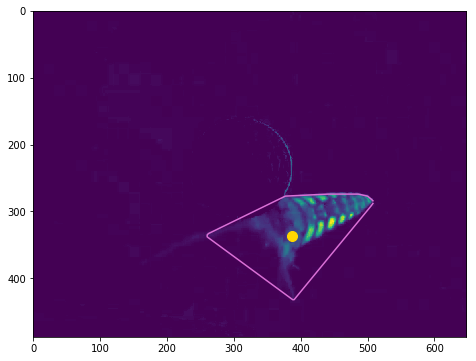

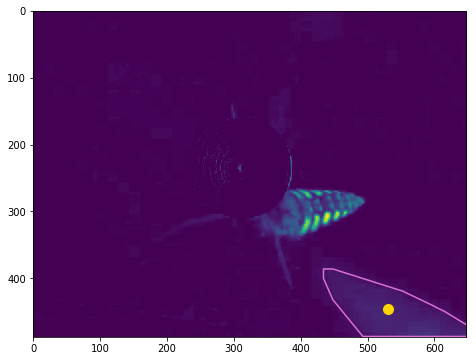

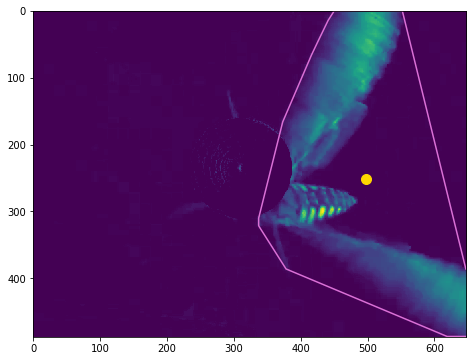

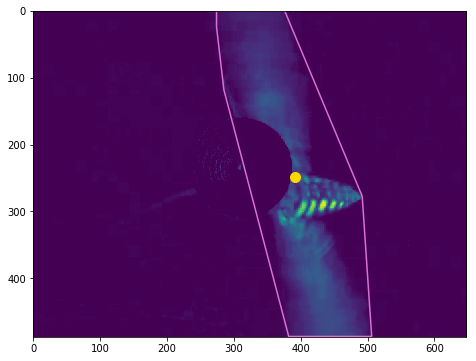

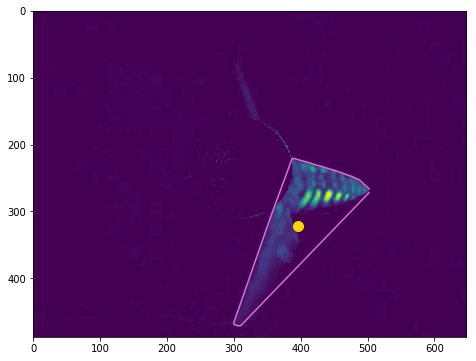

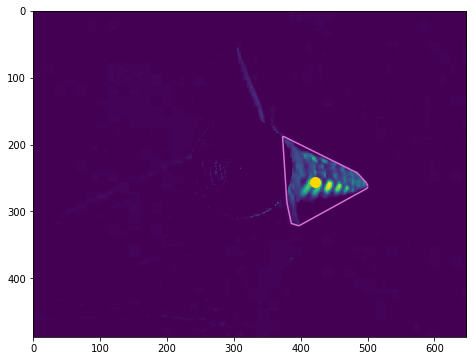

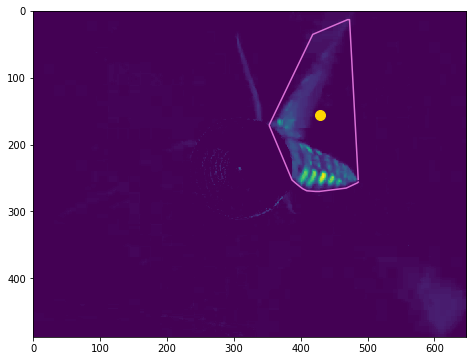

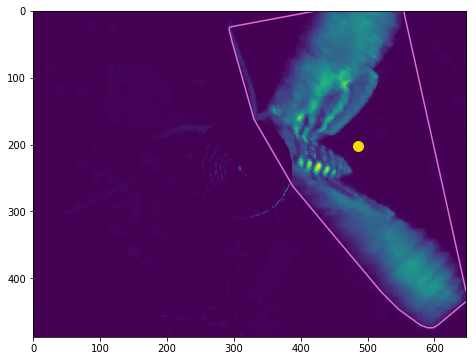

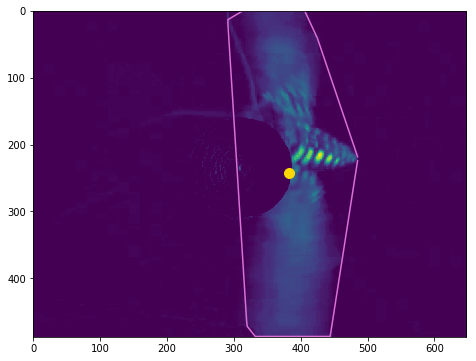

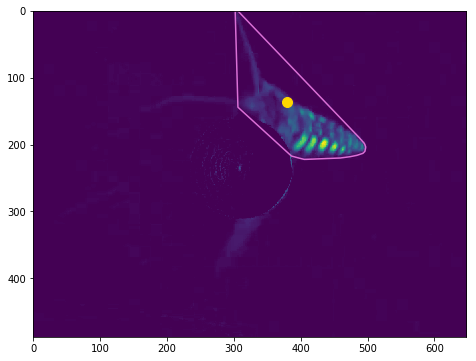

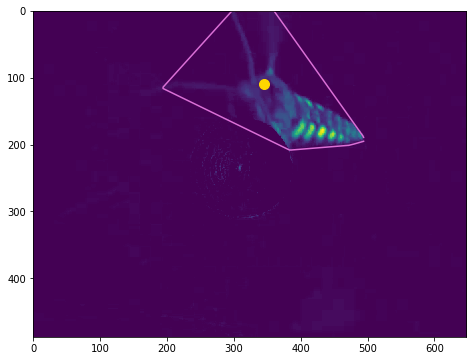

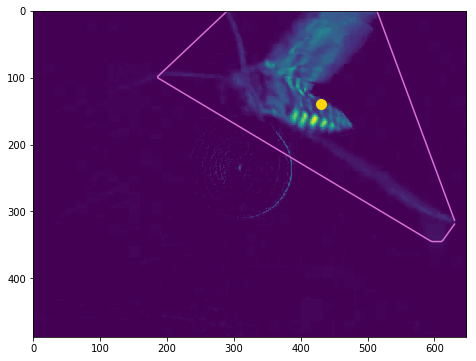

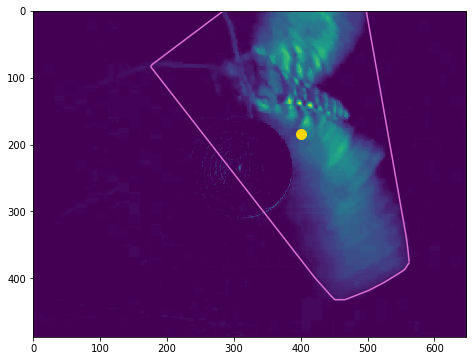

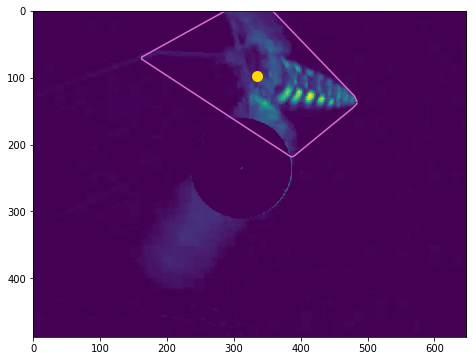

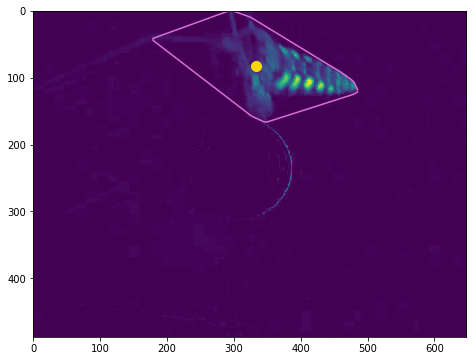

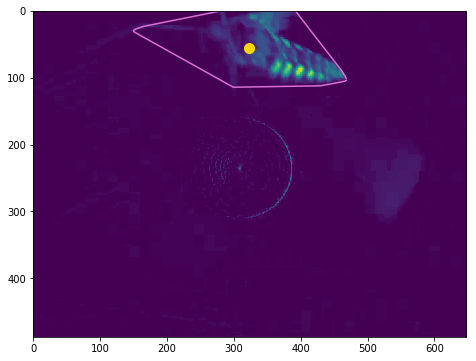

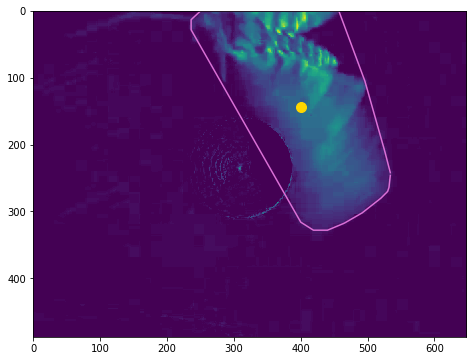

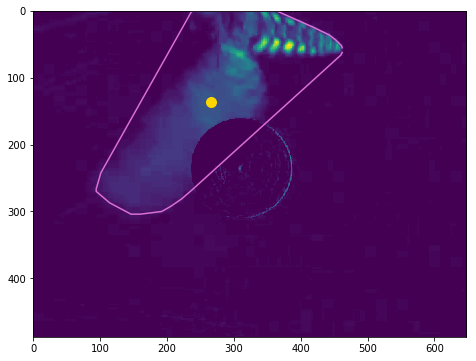

In [15]:
i = 0
for frame in frameNum:
    back, cur, diff = VideoPull(0,frame, filename, location)
    contour, contour_hull, centroid, centroid_hull = MotionParameters(diff)
    if len(contour) >= 1:
        fig = plt.figure(figsize = (20,6))
        plt.imshow(diff)
        plt.plot(np.squeeze(contour_hull)[:,0],np.squeeze(contour_hull)[:,1],'orchid')
        plt.plot(centroids_hull_x[i],centroids_hull_y[i], 'o', color='gold', markersize = 10)
    else: 
        plt.imshow(diff)
    i += 1
# #     outPath_fig = r'/Users/Mahad/Documents/PythonFolder/ImageAnalysis-1/VideoFiles/FrameStills' + ' ' + filename
# #     try:
# #         os.makedirs(outPath_fig)
# #     except OSError as e:
# #         if e.errno != errno.EEXIST:
# #             raise
# #     plt.axis('off')
# i
#     plt.savefig(outPath_fig + '/' + ' ' + filename + "frame number: {}".format(frameNum[i-1]) + '.png')

In [12]:
name_path = '/Users/Mahad/Documents/GitHub2/ManducaMultiSenseFeeding/Infrared/L50_c-3_m6.mat'
